In [1]:
import math
import torch
import random

# Micrograd vs Pytorch

We'll start by verify if all we did with MicroGrad it's correct with Pytorch

In [2]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out
    
    def __radd__(self,other):
        return self + other

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data 
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out 
    
    def __rmul__(self,other):
        return self * other
    
    #we add div
    def __truediv__(self,other):
        return self * other**-1
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), 'f**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data 
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [3]:
# I've just copy/paste this function
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [4]:
x1 = torch.Tensor([2.0]).double()                               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()                 ; x2.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [5]:
print(o.data.item())
o.backward()

0.7071066904050358


In [6]:
print('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

-------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [7]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [8]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'

In [10]:
o.backward()

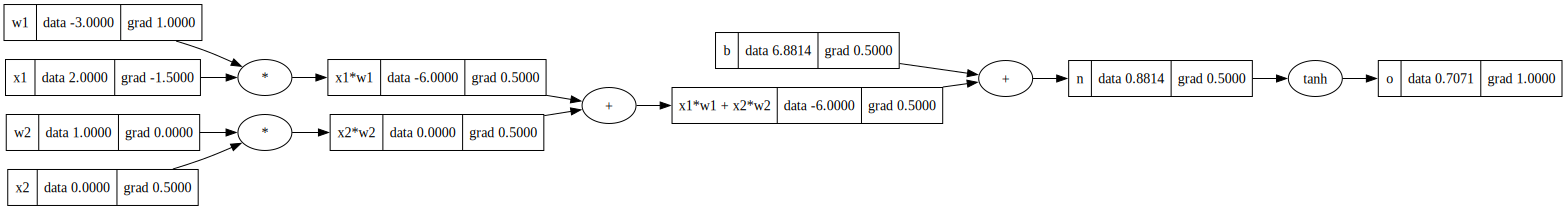

In [11]:
draw_dot(o)

yay !!!!!!!!!!!

# Build our Neural Network

In [12]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi,xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    

In [13]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.9889804138227336)

to be more effecient

In [14]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    

In [15]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.6244621180703888)

For now we have a Neuron
We'll now define a layer

In [16]:
class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs

In [17]:
x = [2.0, 3.0]
n = Layer(2,4)

In [18]:
n(x)

[Value(data=0.9971106564104274),
 Value(data=0.9354121393954764),
 Value(data=-0.9847297191778468),
 Value(data=-0.9486556805014584)]

Excellent

For now, we can define MLP

In [19]:
class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

In [21]:
n(x)

[Value(data=-0.6933219401586647)]

We can make our class NICEEE

In [22]:
class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.06681187757122263)

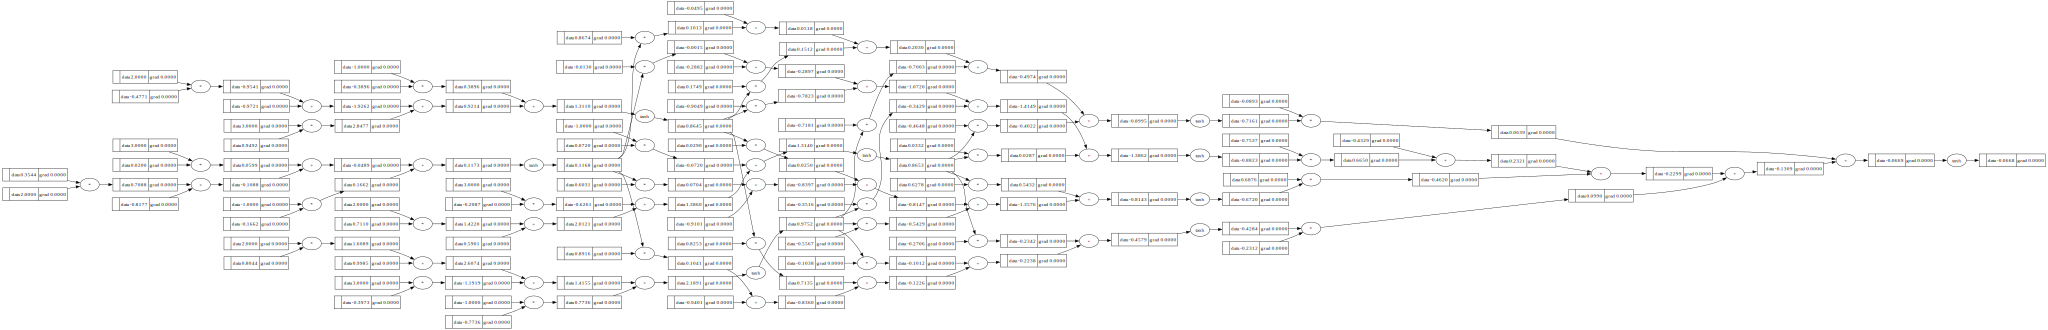

In [24]:
draw_dot(n(x))

We now want to create our dataset and define our loss function

In [25]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0,1.0]

In [28]:
ypred = [n(x) for x in xs]

In [29]:
ypred

[Value(data=-0.06681187757122263),
 Value(data=-0.6642757620070961),
 Value(data=-0.6638590644328406),
 Value(data=-0.33760776484418537)]

In [32]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

In [33]:
loss

Value(data=3.152983607238376)

In [34]:
loss.backward()

In [35]:
n.layers[0].neurons[0].w[0].grad

0.4399897800695771

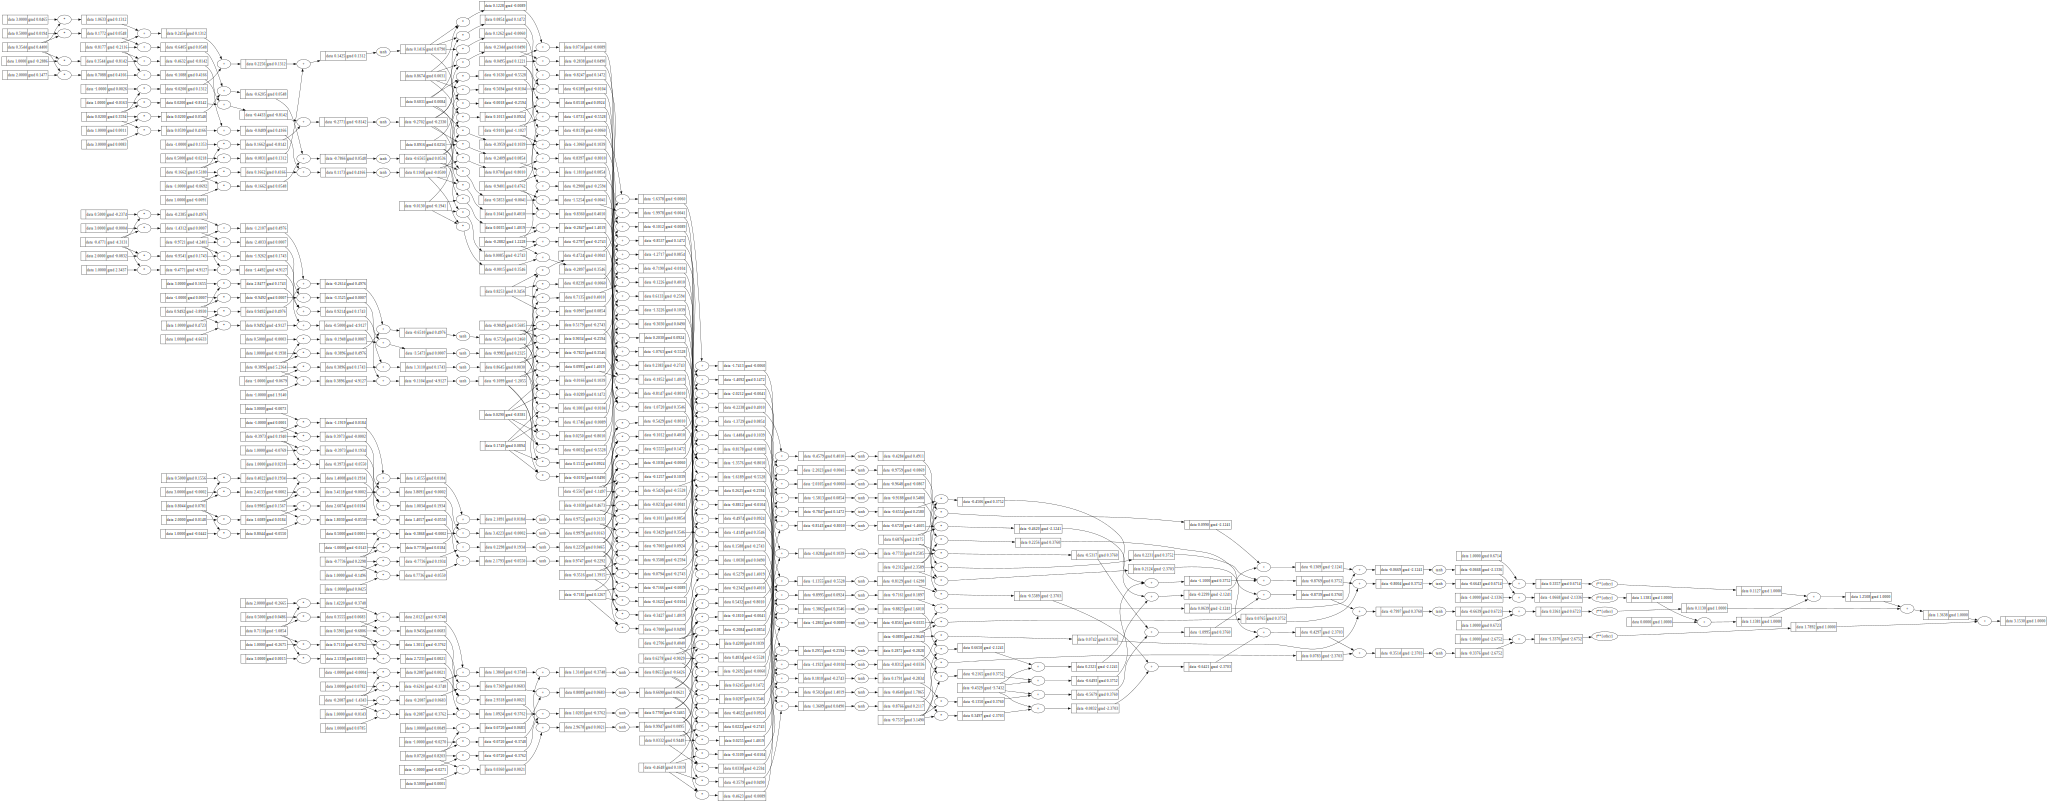

In [36]:
draw_dot(loss)

We'll define a this step the parameters of our network (w,b...)

In [38]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        '''
        

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [39]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

In [41]:
n(x)

Value(data=0.17938454102581644)

In [43]:
len(n.parameters())

41

In [44]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.17938454102581644),
 Value(data=-0.9750994224401037),
 Value(data=-0.7011971097821517),
 Value(data=-0.5502558125295456)]

In [45]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=3.1666060217544074)

In [46]:
loss.backward()

In [47]:
n.layers[0].neurons[0].w[0].grad

6.6181417412165775

In [48]:
n.layers[0].neurons[0].w[0].data

0.026475310017441744

we minimize now our loss

In [49]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [50]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=1.0020807375878258)

we can see that the loss have decreaze

In [51]:
ypred

[Value(data=0.7264111689913171),
 Value(data=-0.9719454974047783),
 Value(data=-0.4301343099992433),
 Value(data=0.22430938552846696)]

We can now automate the process

In [52]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.7018542642533622)

In [53]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0,1.0]

In [54]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 7.086565961625584
1 3.453446154200096
2 2.155475980379868
3 0.6887051213282934
4 0.14486229733034156
5 0.3660003142357171
6 0.47904733362703233
7 0.21387781305673076
8 0.045519170559170374
9 0.0071322739314869325
10 0.0009998007197005003
11 0.00013341049395932425
12 1.7291106553259184e-05
13 2.1933897057028674e-06
14 2.7325326237125043e-07
15 3.34978150804351e-08
16 4.046394758891574e-09
17 4.822010641426562e-10
18 5.675163086692572e-11
19 6.604051271743406e-12


In [55]:
ypred

[Value(data=0.9999981829039226),
 Value(data=-0.9999999999995741),
 Value(data=-0.9999999999995436),
 Value(data=0.9999981828007491)]

yayyy!!!

But!!!!! zero_grad !!!! before backward

In [57]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.056348443163252965)

In [58]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0,1.0]

In [59]:
for k in range(50):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 3.722297774305919
1 1.3388166997897817
2 0.6614826579721458
3 0.44001882670761555
4 0.32039049558014315
5 0.25166167977503884
6 0.21310611441871158
7 0.18478525825320524
8 0.1631417460887725
9 0.14189239627383654
10 0.12605413688033312
11 0.11338197955014918
12 0.10444912464499795
13 0.09673033004658003
14 0.08994932847749545
15 0.08414783096982531
16 0.07817369590518974
17 0.07315898450646804
18 0.06920411019405623
19 0.0651335042334617
20 0.061945816775930244
21 0.05867080911269251
22 0.055713952341021306
23 0.053057209429819514
24 0.05070381782485971
25 0.0487418782722214
26 0.04691101192723663
27 0.04501833097925838
28 0.04341707056413564
29 0.04177460467691241
30 0.04024292816500775
31 0.0389653303661661
32 0.037765463428275775
33 0.03651350786216251
34 0.035323063652159536
35 0.03432104697186893
36 0.03329539902916043
37 0.03239936370651466
38 0.031548577280162804
39 0.03063876588828307
40 0.029888579216965937
41 0.029087173652689684
42 0.028345526624407383
43 0.027690014524560

More slowwww

In [60]:
ypred

[Value(data=0.9259204545817366),
 Value(data=-0.9563490993066825),
 Value(data=-0.904969347822684),
 Value(data=0.9124831647834097)]